## Import libraries

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm.notebook import tqdm_notebook
from My_ViT import VisionTransformer, img_to_patch

In [2]:
model = torch.load('./saved_model.pth')
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = model.to(device)
print("Device:", device)
random.seed(42)
g = torch.Generator().manual_seed(2147483647) # for reproducibility
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: mps


/var/folders/4t/vzt8rmpj2bzg8tyypgszxpqc0000gp/T/ipykernel_49202/1183298594.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./saved_model.pth')


In [3]:
image_size = 28
embed_dim=255
hidden_dim=embed_dim*3
num_heads=3
num_layers=6
patch_size=7
num_patches=16
num_channels=1
num_classes=10
dropout=0.2

## Downloading FashionMNIST from torchvision

In [4]:
# set the preprocess operations to be performed on train/val/test samples
MNIST_preprocess = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                   torchvision.transforms.Normalize((0.5,), (0.5,))])

# download MNIST training set and reserve 50000 for training
train_dataset = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/training', train=True, download=True, transform=MNIST_preprocess)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# download MNIST test set
test_set = torchvision.datasets.FashionMNIST(root='./data/torchvision/FashionMNIST/testing', train=False, download=True, transform=MNIST_preprocess)

# We define the data loaders using the datasets
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_set, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=32, shuffle=False)

## Picking one test sample and running it through the first attention block

In [5]:
test_sample_index = (test_set.targets==1).nonzero(as_tuple=True)[0][5].item()
print(test_sample_index)

41


## Plotting attention
Now we have a normalized squared matrix of size $17\times 17$. When plotting the first column is the class token. The remaining $16$ columns will be reshaped into a $4\times 4$ matrix, ordered in a way where each patch has its position in the image. For better visualization, we'll use `interpolate` function to resize the $4\times 4$ matrix to $28\times 28$.

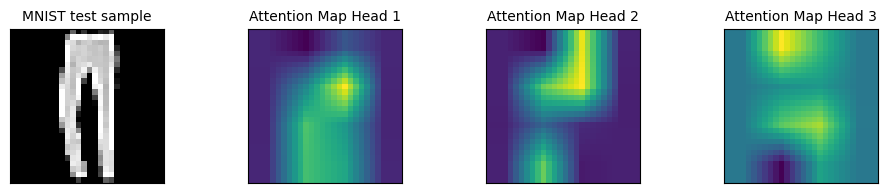

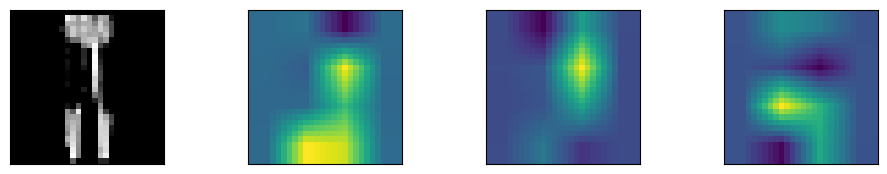

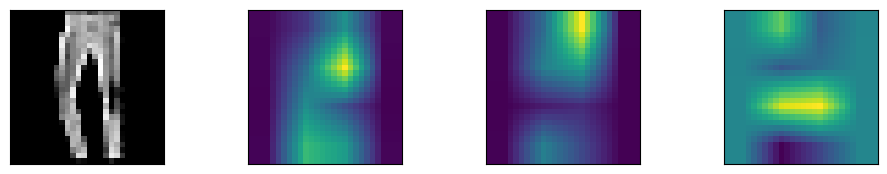

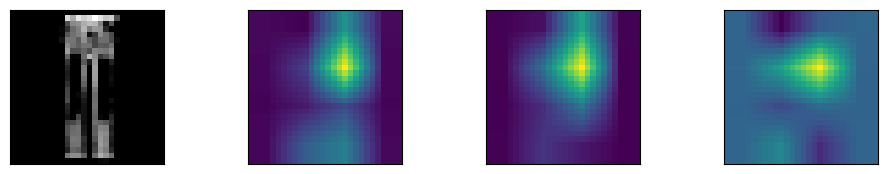

2


In [8]:
def plot_attention_maps(test_sample_index):
    #img_tensor = test_set.data[test_sample_index].to(device)
    img_tensor = test_set[test_sample_index][0].squeeze().to(device)
    img_tensor = (img_tensor * 255).clamp(0, 255).byte()
    patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
    patches = model.input_layer(patches.float())
    transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
    transformer_input_expanded = model.transformer[0].linear[0](transformer_input)[0]

    last_dim = (transformer_input_expanded.shape[0]*transformer_input_expanded.shape[1]) / ((num_patches+1)*3*num_heads)
    qkv = transformer_input_expanded.reshape(num_patches+1, 3, num_heads, int(last_dim))
    q = qkv[:, 0].permute(1, 0, 2)
    k = qkv[:, 1].permute(1, 0, 2)
    kT = k.permute(0, 2, 1)

    attention_matrices = [q[i] @ kT[i] for i in range(num_heads)]

    fig, axes = plt.subplots(1, num_heads + 1, figsize=(12,2))
    img = np.asarray(img_tensor.cpu())

    axes[0].imshow(img, cmap='gray')
    if test_sample_index == test_sample_indices[0]:
      axes[0].set_title('MNIST test sample', fontsize=10)
    axes[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    for i, attention_matrix in enumerate(attention_matrices):
        residual_att = torch.eye(attention_matrix.size(1)).to(device)
        aug_att_mat = attention_matrix + residual_att
        aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

        joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
        joint_attentions[0] = aug_att_mat[0]
        for n in range(1, aug_att_mat.size(0)):
            joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

        attn_heatmap = joint_attentions[0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
        attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)

        axes[i + 1].imshow(attn_heatmap_resized.detach().cpu().numpy())
        if test_sample_index == test_sample_indices[0]:
          axes[i + 1].set_title(f'Attention Map Head {i+1}', fontsize=10)
        axes[i + 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.subplots_adjust(wspace=0.1)
    plt.show()
    plt.close()

# Seleziona 4 immagini di test
test_sample_indices = [(test_set.targets==1).nonzero(as_tuple=True)[0][i].item() for i in range(4)]

# Visualizza le mappe di attenzione per ogni immagine
for idx in test_sample_indices:
    plot_attention_maps(idx)

print (test_sample_indices[0])

Image tensor shape:  torch.Size([28, 28])
Input tensor to Transformer:  torch.Size([1, 17, 255])
transformer_input_expanded shape:  torch.Size([17, 765])
qkv shape:  torch.Size([3, 3, 17, 85])
q shape:  torch.Size([3, 17, 85])
k shape:  torch.Size([3, 17, 85])
attention matrices shape:  torch.Size([3, 17, 17])
attention_matrices_mean shape:  torch.Size([3, 17])


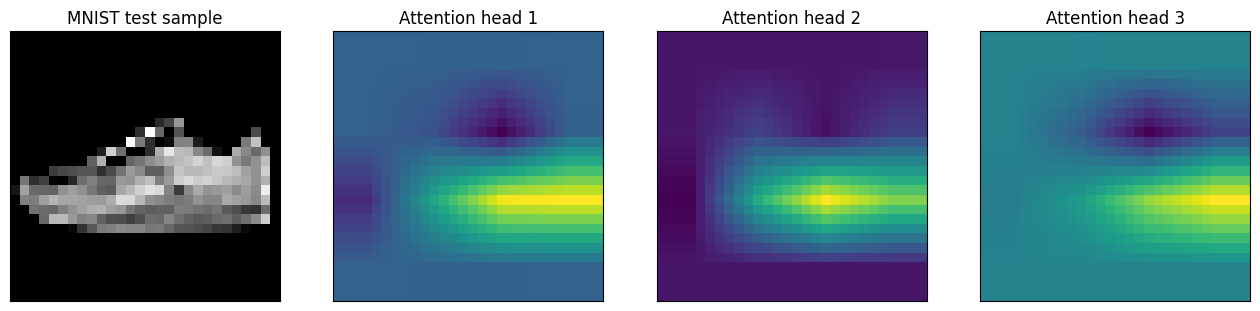

In [9]:
# Estrazione dell'indice del campione di test e preparazione dell'immagine
test_sample_index = (test_set.targets == 7).nonzero(as_tuple=True)[0][12].item()
# Estrazione di un campione di test
#img_tensor = test_set.data[test_sample_index].to(device)
img_tensor = test_set[test_sample_index][0].squeeze().to(device)
img_tensor = (img_tensor * 255).clamp(0, 255).byte()

print ("Image tensor shape: ", img_tensor.shape)
# Conversione dell'immagine in patch
patches = img_to_patch(img_tensor.unsqueeze(0).unsqueeze(0), patch_size=patch_size)
# Passaggio delle patch attraverso lo strato di input per ottenere un tensore di dimensione embed_dim
patches = model.input_layer(patches.float())
# Aggiunta del token di classe e embedding posizionale
transformer_input = torch.cat((model.cls_token, patches), dim=1) + model.pos_embedding
print("Input tensor to Transformer: ", transformer_input.shape)

# Passaggio dell'immagine attraverso il primo blocco di attenzione
transformer_input_expanded = model.transformer[0].linear[0](transformer_input).squeeze(0)
print("transformer_input_expanded shape: ", transformer_input_expanded.shape)

# Reshape del risultato della prima attenzione# Reshape del risultato della prima attenzione
qkv = transformer_input_expanded.reshape(num_patches + 1, 3, -1, num_heads).permute(1, 3, 0, 2)
# Dim: (3, num_heads, num_patches + 1, embedding_size // num_heads)
print("qkv shape: ", qkv.shape)

# Estrazione delle matrici di query e key per tutte le attention heads
q = qkv[0]  # Query matrix (num_heads, num_patches + 1, embedding_size // num_heads)
k = qkv[1]  # Key matrix (num_heads, num_patches + 1, embedding_size // num_heads)
print("q shape: ", q.shape)
print("k shape: ", k.shape)

# Moltiplicazione di q e k^T per ottenere le matrici di attenzione per ciascuna head
kT = k.transpose(-2, -1)  # Trasposizione per fare la moltiplicazione corretta
attention_matrices = torch.matmul(q, kT)  # Dim: (num_heads, num_patches + 1, num_patches + 1)
print("attention matrices shape: ", attention_matrices.shape)

# Normalizzazione delle matrici di attenzione per tutte le heads
attention_matrices_mean = torch.mean(attention_matrices, dim=-1)
print("attention_matrices_mean shape: ", attention_matrices_mean.shape)

# Aggiunta delle connessioni residue e normalizzazione
residual_att = torch.eye(attention_matrices.size(-1)).to(device)
aug_att_mats = attention_matrices + residual_att
aug_att_mats = aug_att_mats / aug_att_mats.sum(dim=-1).unsqueeze(-1)

# Visualizzazione delle heatmap per ciascuna head
fig, axes = plt.subplots(1, 4, figsize=(16, 6))
img = np.asarray(img_tensor.cpu())
axes[0].imshow(img, cmap='gray')
axes[0].set_title('MNIST test sample')
axes[0].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                    labelbottom=False, labeltop=False, labelleft=False, labelright=False)

# Visualizzazione delle heatmap per ogni head
for i in range(3):  # Le prime 3 heads
    attn_heatmap = aug_att_mats[i, 0, 1:].reshape((int(image_size/patch_size), int(image_size/patch_size)))
    attn_heatmap_resized = F.interpolate(attn_heatmap.unsqueeze(0).unsqueeze(0), [image_size, image_size], mode='bilinear').view(28, 28, 1)
    axes[i + 1].imshow(attn_heatmap_resized.detach().cpu().numpy())
    axes[i + 1].set_title(f'Attention head {i + 1}')
    axes[i + 1].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False, labelright=False)

plt.show()
